In [11]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torchvision import transforms
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KDTree

import shapely

import os
import sys

sys.path.append("../scripts")
from data import SmallPatchesDataset
from models import AutoEncoder, DEC

# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def split_rectangle(rect):
    x0, y0, x1, y1 = rect.bounds
    x_mid = (x0 + x1) / 2
    y_mid = (y0 + y1) / 2
    return [
        shapely.geometry.box(x0, y0, x_mid, y_mid),
        shapely.geometry.box(x_mid, y0, x1, y_mid),
        shapely.geometry.box(x0, y_mid, x_mid, y1),
        shapely.geometry.box(x_mid, y_mid, x1, y1)
    ]

def load_patches_selected_scenes(scenes):
    patches_files = [f for f in os.listdir("../data/output/patches") if f.endswith(".geojson")]
    patches_files = [f for f in patches_files if f.split("_")[0] in scenes]
    patches_df = []
    for f in tqdm(patches_files):
        new_df = gpd.read_file("../data/output/patches/" + f)
        for i, row in new_df.iterrows():
            new_geom = split_rectangle(row["geometry"])
            for j in range(4):
                new_row = row.copy()
                new_row["geometry"] = new_geom[j]
                patches_df.append(new_row)
    patches_df = gpd.GeoDataFrame(patches_df)
    return patches_df.reset_index(drop = True)

In [14]:
ny_scenes = gpd.read_file("../data/scenes_metadata/new_york_ny_last_scenes.geojson").entity_id.tolist()
patches_df = load_patches_selected_scenes(ny_scenes)

100%|██████████| 45/45 [00:19<00:00,  2.31it/s]


In [8]:
blocks_df = gpd.read_file("../data/census_blocks.geojson")
blocks_df = blocks_df[blocks_df.state == "36"]
blocks_df = blocks_df[blocks_df.mhi > 0]
blocks_df = blocks_df.reset_index(drop = True)

In [15]:
def get_patch_block_relation(blocks_df, patches_df):
    blocks_centers = np.stack(blocks_df.geometry.apply(lambda x : np.array(x.centroid)).values)
    tree = KDTree(blocks_centers)
    patches_of_block = dict([(i, []) for i in range(blocks_df.shape[0])])

    # for each patch
    for i, row in tqdm(patches_df.iterrows()):

        # verify if it intersects the 7 closest blocks
        centroid = np.array(row["geometry"].centroid).reshape(1, 2)
        idx = tree.query(centroid, k = 7)[1][0]
        patch_area = row["geometry"].area
        intersection_ratio = (blocks_df.iloc[idx].geometry.intersection(row.geometry).area / patch_area).values

        # for each of the 7 closest blocks
        for ii, ratio in enumerate(intersection_ratio):
            if ratio == 0:
                continue

            # save the id of the patch and the ratio of intersection in the block list of patches
            idx_ = idx[ii]
            patches_of_block[idx_].append((i, ratio))
    
    return patches_of_block

In [17]:
import warnings
warnings.filterwarnings('ignore')

patches_of_block = get_patch_block_relation(blocks_df, patches_df)

442964it [59:55, 123.21it/s]


In [19]:
number_patches = [len(a) for a in patches_of_block.values()]
blocks_df["n_patches"] = number_patches

In [32]:
blocks_df_clean = blocks_df[(blocks_df.n_patches < 300) & (blocks_df.n_patches > 0)]

<Axes: >

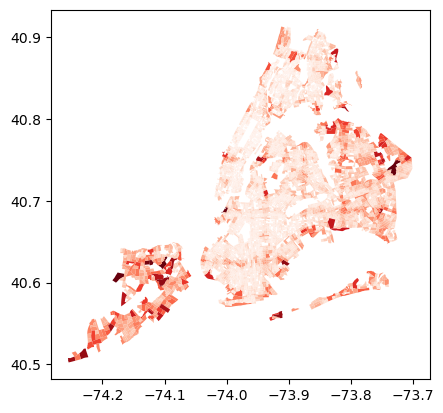

In [33]:
blocks_df_clean.plot(column = "n_patches", cmap = "Reds")

<Axes: >

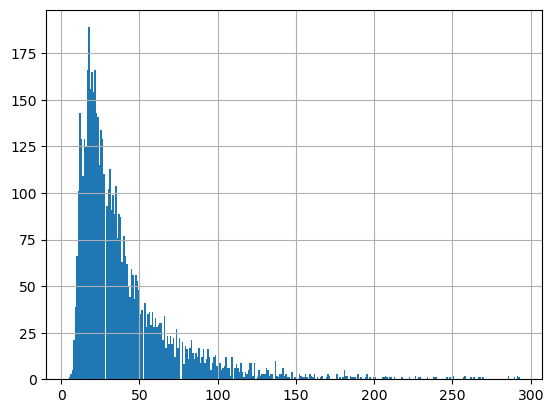

In [36]:
blocks_df_clean.n_patches.hist(bins = 300)

In [46]:
filenames = patches_df.drop_duplicates(subset = ["patche_filename"]).patche_filename.values.tolist()
filenames = ["../data/output/patches/" + f for f in filenames]
dataset = SmallPatchesDataset(filenames)
dl = torch.utils.data.DataLoader(dataset, batch_size = 64)

In [44]:
k = 20
latent_dim = 100
model_autoencoder = AutoEncoder(latent_dim, encoder_arch= "resnet50", decoder_layers_per_block = [3] * 5)
encoder = model_autoencoder.encoder
model = DEC(k, latent_dim, encoder)
model.load_state_dict(torch.load(f"../models/DEC_resnet50_clusters_{k}_v2/model.pt"));

In [49]:
device = torch.device("cuda")
model.to(device)
cluster_distribution = []
for batch, _ in tqdm(dl):
    batch = batch.to(device)
    batch_size = batch.shape[0]
    z = model(batch).detach().cpu().numpy().reshape(batch_size, -1)
    cluster_distribution.append(z)
cluster_distribution = np.concatenate(cluster_distribution)

100%|██████████| 6922/6922 [27:17<00:00,  4.23it/s]


In [51]:
clusters = np.argmax(cluster_distribution, axis = 1)

In [129]:
def get_block_cluster_count(block_id):
    patches_id = [x[0] for x in patches_of_block[block_id]]
    cluster_dist = np.zeros(k)
    for i in patches_id:
        #cluster_dist[clusters[i]] += 1
        cluster_dist += cluster_distribution[i, :]
    return cluster_dist

In [138]:
block_cluster_count = np.stack(blocks_df_clean.index.map(get_block_cluster_count).values)
for i in range(k):
    blocks_df_clean[f"cluster_{i}"] = block_cluster_count[:, i]
#for i in range(k):
#    blocks_df_clean[f"cluster_{i}"] /= blocks_df_clean[[f"cluster_{i}" for i in range(k)]].sum(axis = 1)

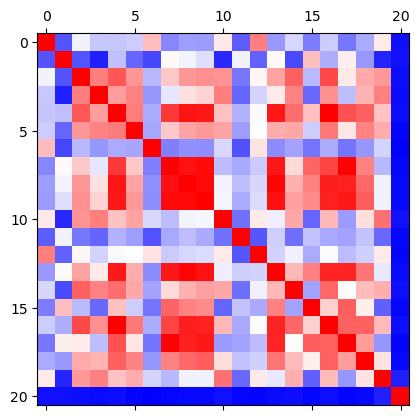

In [139]:
plt.matshow(blocks_df_clean[["cluster_"+str(i) for i in range(20)] + ["mhi"]].corr(), cmap = "bwr")
plt.show()

In [140]:
x_train, x_test, y_train, y_test = train_test_split(blocks_df_clean.iloc[:, -20:], blocks_df_clean.mhi, test_size=0.2, random_state=42)

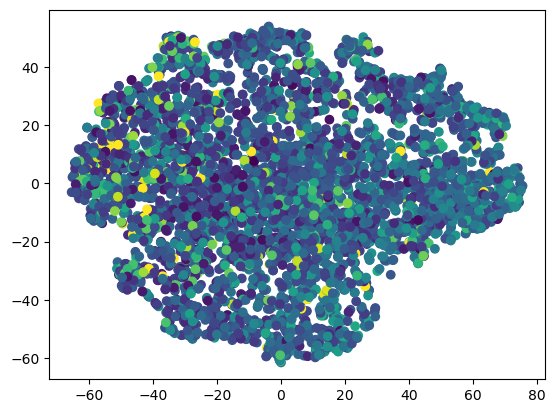

In [141]:
x_train_proj = TSNE(n_components=2).fit_transform(StandardScaler().fit_transform(x_train))

plt.scatter(x_train_proj[:, 0], x_train_proj[:, 1], c = y_train, cmap = "viridis")

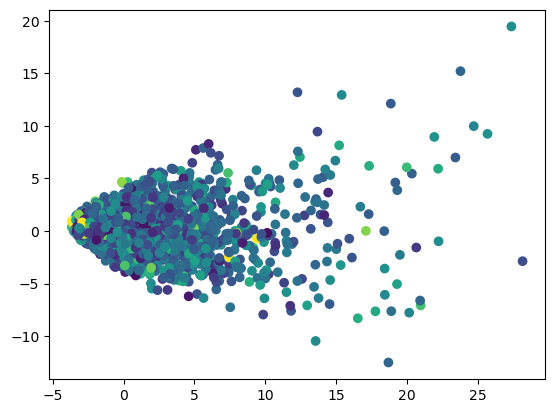

In [142]:
x_train_proj = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(x_train))

plt.scatter(x_train_proj[:, 0], x_train_proj[:, 1], c = y_train, cmap = "viridis")

In [143]:
svr = SVR()
parameters = {
    "kernel": ["linear", "rbf"],
    "C": [0.1, 1, 10, 100],
    "gamma": [0.1, 1, 10, 100]
}
clf = GridSearchCV(svr, parameters)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Train")
print("MAE:", mean_absolute_error(y_train, clf.predict(x_train)))
print("R2:", r2_score(y_train, clf.predict(x_train)))
print("Test")
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("R2: ", r2_score(y_test, y_pred))

Train
MAE: 34756.87813726389
R2: -0.0324014664608554
Test
MAE:  35837.22897129165
R2:  -0.051973984944541085


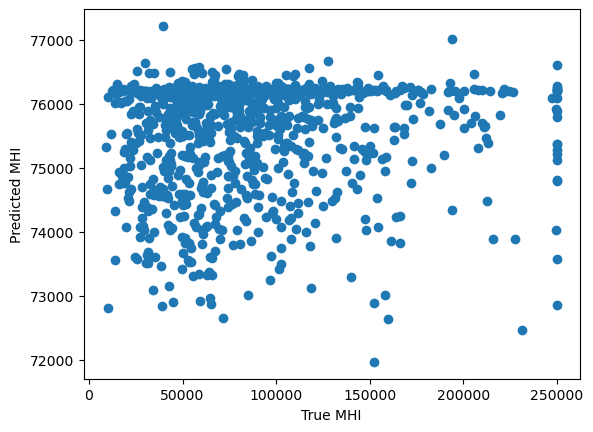

In [144]:
plt.plot(y_test, y_pred, "o")
plt.xlabel("True MHI")
plt.ylabel("Predicted MHI")
plt.show()

In [145]:
rf = RandomForestRegressor()
parameters = {
    "n_estimators": [10, 100, 1000],
    "max_depth": [None, 10, 100],
    "min_samples_split": [2, 10, 100],
}
clf = GridSearchCV(rf, parameters)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Train")
print("MAE:", mean_absolute_error(y_train, clf.predict(x_train)))
print("R2:", r2_score(y_train, clf.predict(x_train)))
print("Test")
print("MAE: ", np.sqrt(mean_absolute_error(y_test, y_pred)))
print("R2: ", r2_score(y_test, y_pred))

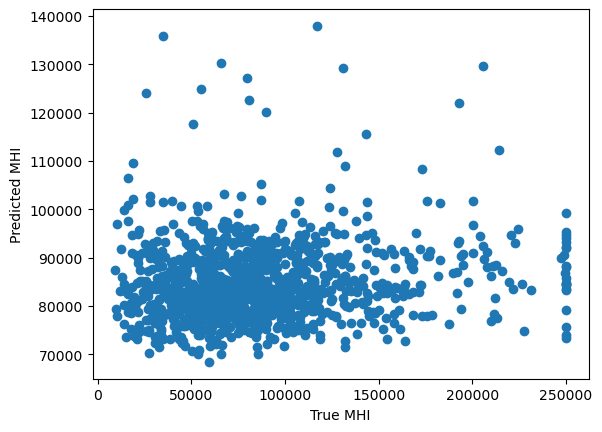

In [ ]:
plt.plot(y_test, y_pred, "o")
plt.xlabel("True MHI")
plt.ylabel("Predicted MHI")
plt.show()

## Testing with kmeans

In [ ]:
k = 20
latent_dim = 100
model = AutoEncoder(latent_dim, encoder_arch= "resnet50", decoder_layers_per_block = [3] * 5)
model.load_state_dict(torch.load(f"../models/AE_resnet_v2/model.pt"))

In [ ]:
device = torch.device("cuda")
model.to(device)
embeddings = []
for batch, _ in tqdm(dl):
    batch = batch.to(device)
    batch_size = batch.shape[0]
    z = model(batch).detach().cpu().numpy().reshape(batch_size, -1)
    embeddings.append(z)
embeddings = np.concatenate(embeddings)